In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from gbm import test_data_dir as tdd
from gbm.binning.unbinned import bin_by_time as bbt
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
from gbm.data import Cspec
from gbm.data import TTE, RSP
from gbm.data import PHA
from gbm.plot import Lightcurve, Spectrum, ModelFit
from gbm.spectra.fitting import SpectralFitterPgstat
from gbm.spectra.functions import Band, PowerLaw, Comptonized

In [2]:
downloads_path = "Datos/bn090926181/current/"

pha_file_n7 = os.path.join(downloads_path, "glg_cspec_n7_bn090926181_v00.pha")
rsp2_file_n7 = os.path.join(downloads_path, "glg_cspec_n7_bn090926181_v00.rsp2")

tte_file = os.path.join(downloads_path, "glg_tte_n7_bn090926181_v00.fit")
rsp_file = os.path.join(downloads_path, "glg_cspec_n7_bn090926181_v00.rsp2")

tte = TTE.open(tte_file)
rsp = RSP.open(rsp_file)
cspec_n7 = Cspec.open(pha_file_n7)

phaii = tte.to_phaii(bbt, 1.024, time_ref=0.0)

print(" CSPEC n7 cargado")
print(" Matriz de respuesta .rsp2 disponible")

 CSPEC n7 cargado
 Matriz de respuesta .rsp2 disponible


In [3]:
bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=1)
backfitter.statistic/backfitter.dof

bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
type(bkgd)

gbm.background.background.BackgroundRates

In [4]:
# Se comienza a trabajar con el destello
erange = (0.0, 900.0)
lc_data = cspec_n7.to_lightcurve(energy_range=erange)
time_range = (-25, 150)

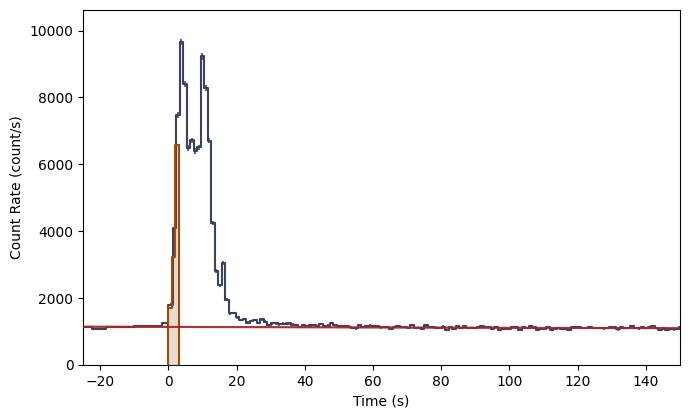

In [6]:
src_time = (0.0, 3.0) # Selección del bin

# Ajuste y gráfica del destello junto con el bin
lc_bkgd0 = bkgd.integrate_energy(*erange)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

spec_data = phaii.to_spectrum(time_range=src_time, energy_range=erange)
spec_bkgd = bkgd.integrate_time(*src_time)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd0)
lcplot.add_selection(src_lc)
lcplot.xlim = time_range

In [8]:
phaii_data = phaii.to_pha(time_ranges=src_time, energy_range=erange)
bkgd_data = bkgd.to_bak(time_range=src_time)

type(phaii_data), type(bkgd_data)
drm = rsp.interpolate(phaii_data.tcent)

specfitter = SpectralFitterPgstat(
    [phaii_data],           # Lista co phaii_data
    [spec_bkgd],            # Lista con spec_bkgd
    [drm],                  # Lista on DRM
    method = 'TNC'
)

In [9]:
band = Band()
band.param_list

[('A', 'ph/s/cm^2/keV', 'Amplitude'),
 ('Epeak', 'keV', 'SED Peak'),
 ('alpha', '', 'Low-Energy Photon index'),
 ('beta', '', 'High-Energy Photon index'),
 ('Epiv', 'keV', 'Pivot energy')]

In [10]:
print(band.default_values)
print(band.min_values)
print(band.max_values)

[0.01, 500.0, -0.5, -2.5, 100.0]
[1e-10, 0.01, -1.9, -10.0, 0.01]
[inf, inf, 20.0, -2.0001, inf]


In [12]:
band.max_values[3] = -1.5
print("band Fit:")
specfitter.fit(band, options={'maxiter': 1000})

print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('90% Asym. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
print('Pgstat/DoF: {}'.format(specfitter.statistic, specfitter.dof))

band Fit:
Converged (|f_n-f_(n-1)| ~= 0)
Parameters: [ 1.57312247e-01  2.56862587e+02 -3.36863172e-01 -1.92386285e+00]
90% Asym. Errors:
 [[5.58515148e-03 5.71785454e-03]
 [1.04054443e+01 1.07699867e+01]
 [4.91705542e-02 5.14982606e-02]
 [2.35177484e-01 1.59951422e-01]]
Pgstat/DoF: 69.7291551314621


In [14]:
params = specfitter.parameters
errors = specfitter.asymmetric_errors(cl=0.9)
band.max_values[3] = -1.5

param_names = ['Amplitud (A)', 'Epeak', 'Alpha', 'Beta']
units = ['ph/s/cm^2/keV', 'keV', '', '']

print("=" * 90)
print(f"{'Parámetro':<20} {'Valor':<15} {'Error':<15} {'Error %':<10}")
print("=" * 90)

for i in range(len(params)):
    error_neg = errors[i][0]
    error_pos = errors[i][1]

    avg_error = (abs(error_neg)+abs(error_pos))/2
    error_percent = (avg_error/abs(params[i]))*100

    print(f"{param_names[i]:<20} {params[i]:<15.4f} {avg_error:<15.4f} {error_percent:<10.1f}% {units[i]}")

print("="*90)

Parámetro            Valor           Error           Error %   
Amplitud (A)         0.1573          0.0057          3.6       % ph/s/cm^2/keV
Epeak                256.8626        10.5877         4.1       % keV
Alpha                -0.3369         0.0503          14.9      % 
Beta                 -1.9239         0.1976          10.3      % 


In [ ]:
# === Auto-búsqueda del mejor bin (1 s) con error ≤20%, usando GBM Data Tools (Pgstat) ===

# 1) Detectar objetos ya cargados en el notebook
phaii_obj = None
for name in ("cspec", "phaii"):
    if name in globals():
        phaii_obj = globals()[name]
        break
if phaii_obj is None:
    raise RuntimeError("No encuentro 'cspec' ni 'phaii' en el espacio global.")

# Fondo (usar bkgd si existe; si no, derivarlo desde backfitter)
if "bkgd" in globals():
    bkgd_obj = bkgd
elif "backfitter" in globals():
    bkgd_obj = backfitter.interpolate_bins(phaii_obj.data.tstart, phaii_obj.data.tstop)
else:
    raise RuntimeError("No encuentro 'bkgd' ni 'backfitter'. Calcula primero el fondo.")

# Respuesta del detector (RSP/RSP2 interpolable)
if "rsp" not in globals():
    raise RuntimeError("No encuentro 'rsp'. Carga la respuesta del detector antes de seguir.")

# 2) Configuración
time_window = (-5.0, 20.0)   # rango donde buscar
bin_size    = 1.0            # ancho del bin [s]
step        = 1.0            # paso entre inicios (usa 0.5 para solapados)
erange_fit  = (8.0, 900.0)   # keV
THRESH_REL  = 0.20           # 20% para A y Epeak (error relativo)
THRESH_ABS  = 0.20           # 0.2 para α y β (error absoluto)

# 3) Utilidades
def time_bins(t0, t1, width, step):
    starts = np.arange(t0, t1 - width + step, step)
    return [(t, min(t + width, t1)) for t in starts if t < t1]

def build_pha(phaii, bkgd, tr, erange):
    # PHA del dato y fondo integrado para ese bin
    pha  = phaii.to_pha(time_ranges=tr, energy_range=erange)       # single-detector: devuelve 1 PHA
    bint = bkgd.integrate_time(*tr)                                 # fondo integrado (obj. compatible)
    drm  = rsp.interpolate(pha.tcent)                               # DRM en el centro del bin
    return pha, bint, drm

def make_model(use_band=True):
    if use_band:
        m = Band(); m.beta.value = -2.2
    else:
        m = Comptonized()
    m.A.value      = 0.1
    m.Epeak.value  = 200.0
    m.alpha.value  = -0.9
    m.Epiv.value   = 100.0
    return m

def values_and_sigmas(specfitter):
    """
    Extrae vector de parámetros y 1o de la matriz de covarianza.
    Orden para Band: [A, Epeak, alpha, beta, Epiv]; para Comptonized: [A, Epeak, alpha, Epiv].
    """
    vals = np.array(specfitter.parameters, dtype=float)
    cov  = np.array(specfitter.covariance, dtype=float) if hasattr(specfitter, "covariance") else None
    sigs = np.sqrt(np.clip(np.diag(cov), 0, np.inf)) if cov is not None else np.full_like(vals, np.inf)
    return vals, sigs

def metrics_from_fit(specfitter, model_name):
    vals, sigs = values_and_sigmas(specfitter)
    # mapear nombres → índices según modelo:
    if model_name == "Band":
        idx = {"A":0, "Epeak":1, "alpha":2, "beta":3}
    else:  # "Comp"
        idx = {"A":0, "Epeak":1, "alpha":2}
    # errores relativos y absolutos
    def rel(name):
        i = idx[name]; v, s = abs(vals[i]), abs(sigs[i])
        return np.inf if (v == 0 or not np.isfinite(s)) else s / v
    def abserr(name):
        i = idx[name]; s = abs(sigs[i])
        return s if np.isfinite(s) else np.inf
    # criterio de pase
    A_ok   = rel("A")      <= THRESH_REL
    Ep_ok  = rel("Epeak")  <= THRESH_REL
    a_ok   = abserr("alpha") <= THRESH_ABS
    b_ok   = True
    if model_name == "Band":
        b_ok = abserr("beta") <= THRESH_ABS
    passed = A_ok and Ep_ok and a_ok and b_ok
    # score: peor (máximo) de los errores clave
    scores = [rel("A"), rel("Epeak"), abserr("alpha")]
    if model_name == "Band": scores.append(abserr("beta"))
    score = np.max(scores)
    # gof
    gof = specfitter.statistic / specfitter.dof if hasattr(specfitter, "dof") else np.inf
    return passed, score, gof, vals, sigs

# 4) Loop por bins y modelos
candidatos = []  # (key=(score,gof), passed, model_name, specfitter, (t0,t1))

for (t0, t1) in time_bins(*time_window, bin_size, step):
    try:
        pha, bint, drm = build_pha(phaii_obj, bkgd_obj, (t0, t1), erange_fit)
    except Exception:
        continue

    # SpectralFitterPgstat espera listas (puedes pasar una lista de 1 elemento)
    for model_name in ("Band", "Comp"):
        try:
            fitter = SpectralFitterPgstat([pha], [bint], [drm], method="TNC")
            model  = make_model(use_band=(model_name == "Band"))
            fitter.fit(model, options={"maxiter": 1000})
            passed, score, gof, vals, sigs = metrics_from_fit(fitter, model_name)
            candidatos.append(((score, gof), passed, model_name, fitter, (t0, t1)))
        except Exception:
            continue

if not candidatos:
    raise RuntimeError("No hubo candidatos de ajuste. Revisa ventana temporal/energía o el fondo.")

# 5) Elegir ganador: si hay alguno que pase ≤20%, tomar el mejor entre esos; si no, el mejor global
pasados  = [c for c in candidatos if c[1]]
ganador  = min(pasados, key=lambda x: x[0]) if pasados else min(candidatos, key=lambda x: x[0])
(key, passed, model_name, specfitter, (t0, t1)) = ganador
vals, sigs = values_and_sigmas(specfitter)

print(f"Mejor bin: {t0:.3f}–{t1:.3f} s | Modelo={model_name} | score(max.err)={key[0]:.3f} "
      f"| {'PASÓ ≤20%' if passed else 'NO PASÓ (mejor disponible)'}")
print(f"Pgstat/DoF ≈ {getattr(specfitter, 'statistic', np.nan):.1f}/{getattr(specfitter, 'dof', np.nan)}")
# nombres de parámetros según modelo
names = ["A","Epeak","alpha"] + (["beta"] if model_name=="Band" else []) + ["Epiv"]
for i, n in enumerate(names):
    if i < len(vals):
        print(f"  {n:6s} = {vals[i]:.5g} ± {sigs[i]:.3g}")

# 6) Graficar el ajuste del bin ganador con la clase oficial de plotting
modelplot = ModelFit(fitter=specfitter)  # ver doc: plotting con ModelFit
modelplot.ax.grid(which='both')
plt.title(f"{model_name} | {t0:.2f}–{t1:.2f} s")
plt.show()

RuntimeError: No hubo candidatos de ajuste. Revisa ventana temporal/energía o el fondo.

In [23]:
# ====== Detectar objetos ======
ph = None
for _n in ("cspec","phaii"):
    if _n in globals():
        ph = globals()[_n]; break
if ph is None:
    raise RuntimeError("No encuentro 'cspec' ni 'phaii'.")

if "bkgd" in globals():
    bk = bkgd
elif "backfitter" in globals():
    bk = backfitter.interpolate_bins(ph.data.tstart, ph.data.tstop)
else:
    raise RuntimeError("No encuentro 'bkgd' ni 'backfitter'.")

if "rsp" not in globals():
    raise RuntimeError("No encuentro 'rsp' (respuesta). Cárgala antes.")

# ====== Config ======
ENERANGE = (8.0, 900.0)   # keV
BIN_SIZE  = 1.0
STEP      = 1.0           # 0.5 si se quieren solapados
TH_REL    = 0.20
TH_ABS    = 0.20

# ====== Imports GBM (API moderna) ======
from gbm.spectra.fitting import SpectralFitterPgstat
from gbm.spectra.functions import Band, Comptonized
from gbm.plot import ModelFit

# ====== Utilidades ======
def safe_time_window():
    # Intersección: datos, fondo y respuesta
    tmin_data, tmax_data = ph.data.tstart.min(), ph.data.tstop.max()
    tmin_bk, tmax_bk = tmin_data, tmax_data
    # rsp2 suele poder interpolarse en el centro del bin; usaremos el rango de datos
    t0 = max(tmin_data, tmin_bk)
    t1 = min(tmax_data, tmax_bk)
    # expande un poquito si hace falta
    return float(t0), float(t1)

def time_bins(t0, t1, width, step):
    s = np.arange(t0, t1 - width + step, step)
    return [(t, min(t+width, t1)) for t in s if t < t1]

def build_pha_robust(phaii, bkgd, tr, erange):
    # Intento A: limitar por energy_range en la conversión a PHA
    try:
        pha = phaii.to_pha(time_ranges=tr, energy_range=erange)
        bgi = bkgd.integrate_time(*tr)
        return pha, bgi, None
    except Exception as eA:
        # Intento B: sin energy_range; luego recortamos canales por bordes
        pha = phaii.to_pha(time_ranges=tr)
        bgi = bkgd.integrate_time(*tr)
        # recortar canales por ERANGE
        Emin, Emax = erange
        eb = np.asarray(pha.ebounds)
        mask = (eb[:,0] >= Emin) & (eb[:,1] <= Emax)
        if not np.any(mask):
            raise RuntimeError(f"PHA sin canales dentro de {erange} keV ({eA})")
        pha = pha.select_channels(mask)
        bgi = bgi.select_channels(mask)
        return pha, bgi, None

def interp_rsp(drm_obj, pha):
    # Interpolar DRM al centro del bin (atributo estándar: tcent en PHA)
    tcent = float(pha.tcent)
    try:
        drm = rsp.interpolate(tcent)
    except Exception as e:
        raise RuntimeError(f"RSP no interpolable en t={tcent:.3f}s: {e}")
    return drm

def make_model(name):
    if name == "Band":
        m = Band(); m.beta.value = -2.2
    else:
        m = Comptonized()
    m.A.value, m.Epeak.value, m.alpha.value, m.Epiv.value = 0.1, 200.0, -0.9, 100.0
    return m

def vals_sigs(ftr, model):
    v = np.array(ftr.parameters, dtype=float)
    cov = np.array(ftr.covariance, dtype=float) if hasattr(ftr, "covariance") else None
    s = np.sqrt(np.clip(np.diag(cov),0,np.inf)) if cov is not None else np.full_like(v, np.inf)
    names = ["A","Epeak","alpha"] + (["beta"] if model=="Band" else []) + ["Epiv"]
    return v, s, names

def rel(v,s): return np.inf if (not np.isfinite(s) or v==0) else abs(s)/abs(v)

def pass_criteria(v,s,names,model):
    idx = {n:i for i,n in enumerate(names) if i<len(v)}
    A_ok  = rel(v[idx["A"]],      s[idx["A"]])      <= TH_REL
    Ep_ok = rel(v[idx["Epeak"]],  s[idx["Epeak"]])  <= TH_REL
    a_ok  = abs(s[idx["alpha"]])  <= TH_ABS
    b_ok  = True
    if model=="Band" and "beta" in idx:
        b_ok = abs(s[idx["beta"]]) <= TH_ABS
    return A_ok and Ep_ok and a_ok and b_ok

def score_error(v,s,names,model):
    idx = {n:i for i,n in enumerate(names) if i<len(v)}
    errs = [
        rel(v[idx["A"]],     s[idx["A"]]),
        rel(v[idx["Epeak"]], s[idx["Epeak"]]),
        abs(s[idx["alpha"]]),
    ]
    if model=="Band" and "beta" in idx:
        errs.append(abs(s[idx["beta"]]))
    return float(np.max(errs))

# ====== Loop con diagnóstico ======
t0s, t1s = safe_time_window()
# Si quieres forzar una ventana particular, cámbiala aquí:
# t0s, t1s = -5.0, 20.0

bins = time_bins(t0s, t1s, BIN_SIZE, STEP)
candidatos, errores = [], []
models = ("Band","Comp")

for (t0,t1) in bins:
    try:
        pha, bgi, _ = build_pha_robust(ph, bk, (t0,t1), ENERANGE)
        drm = interp_rsp(rsp, pha)
    except Exception as e:
        if len(errores) < 10: errores.append((t0,t1,f"prep: {e}"))
        continue

    local_best = None
    for mname in models:
        try:
            fitter = SpectralFitterPgstat([pha],[bgi],[drm], method="TNC")
            model  = make_model(mname)
            fitter.fit(model, options={"maxiter": 1000})
            v,s,names = vals_sigs(fitter, mname)
            score = score_error(v,s,names,mname)
            gof   = getattr(fitter, "statistic", np.inf)/getattr(fitter,"dof", np.inf)
            passed = pass_criteria(v,s,names,mname)
            key = (score, gof)
            item = (key, passed, mname, fitter, (t0,t1))
            if (local_best is None) or (key < local_best[0]):
                local_best = item
        except Exception as e:
            if len(errores) < 10: errores.append((t0,t1,f"{mname}: {e}"))
            continue

    if local_best: candidatos.append(local_best)

if not candidatos:
    print("⚠️ No hubo candidatos. Primeros errores detectados (máx 10):")
    for t0,t1,msg in errores:
        print(f"  bin {t0:.3f}-{t1:.3f}s -> {msg}")
    raise RuntimeError("No hubo candidatos de ajuste. Revisa mensajes arriba.")

# Elegir ganador
pasados = [c for c in candidatos if c[1]]
ganador = min(pasados, key=lambda x: x[0]) if pasados else min(candidatos, key=lambda x: x[0])
(key, passed, model_name, specfitter, (t0,t1)) = ganador

v,s,names = vals_sigs(specfitter, model_name)
print(f"\n✅ Mejor bin: {t0:.3f}–{t1:.3f} s | Modelo={model_name} | score={key[0]:.3f} | "
      f"{'PASÓ ≤20%' if passed else 'NO PASÓ (mejor disponible)'}")
try:
    print(f"Pgstat/DoF ≈ {specfitter.statistic:.1f}/{specfitter.dof}")
except Exception:
    pass
for i,nm in enumerate(names):
    if i < len(v):
        print(f"  {nm:6s} = {v[i]:.5g} ± {s[i]:.3g}")

# ====== Plot ======
mf = ModelFit(fitter=specfitter)
mf.ax.grid(which='both', ls=':')
plt.title(f"{model_name} | {t0:.2f}–{t1:.2f} s")
plt.show()

⚠️ No hubo candidatos. Primeros errores detectados (máx 10):
  bin -27.648--26.648s -> Band: 'Band' object has no attribute 'beta'
  bin -27.648--26.648s -> Comp: 'Comptonized' object has no attribute 'A'
  bin -26.648--25.648s -> Band: 'Band' object has no attribute 'beta'
  bin -26.648--25.648s -> Comp: 'Comptonized' object has no attribute 'A'
  bin -25.648--24.648s -> Band: 'Band' object has no attribute 'beta'
  bin -25.648--24.648s -> Comp: 'Comptonized' object has no attribute 'A'
  bin -24.648--23.648s -> Band: 'Band' object has no attribute 'beta'
  bin -24.648--23.648s -> Comp: 'Comptonized' object has no attribute 'A'
  bin -23.648--22.648s -> Band: 'Band' object has no attribute 'beta'
  bin -23.648--22.648s -> Comp: 'Comptonized' object has no attribute 'A'


RuntimeError: No hubo candidatos de ajuste. Revisa mensajes arriba.